## 1. Setup and Imports

In [1]:
# --- standard libs ---
import sys
from pathlib import Path

# --- third-party libs ---
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- project root (for Jupyter) ---
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# --- project imports ---
from edh import EDHFilter
from ekf_ukf_pf.ekf import ExtendedKalmanFilter

from ekf_ukf_pf import utils


# --- reproducibility ---
tf.random.set_seed(42)
np.random.seed(42)

# --- environment info (optional) ---
print(f"TensorFlow {tf.__version__}")
print(f"GPU available: {bool(tf.config.list_physical_devices('GPU'))}")

TensorFlow 2.20.0
GPU available: False


## 2. Initialize non-linear Range-Bearing Model: Generate Data

In [2]:
# Create model and generate trajectory using utils
dt = 1.0
rb_model = utils.create_model(
    dt=dt, 
    process_noise_std_pos=0.1, 
    process_noise_std_vel=0.1,
    range_noise_std=50.0, 
    bearing_noise_std=0.005, 
    seed=42
)

T = 100
true_states, obs = utils.generate_trajectory(rb_model, T=T)

print(f"Generated {T} observations")
print(f"True states: {true_states.shape}, Observations: {obs.shape}")

Generated 100 observations
True states: (4, 101), Observations: (2, 100)


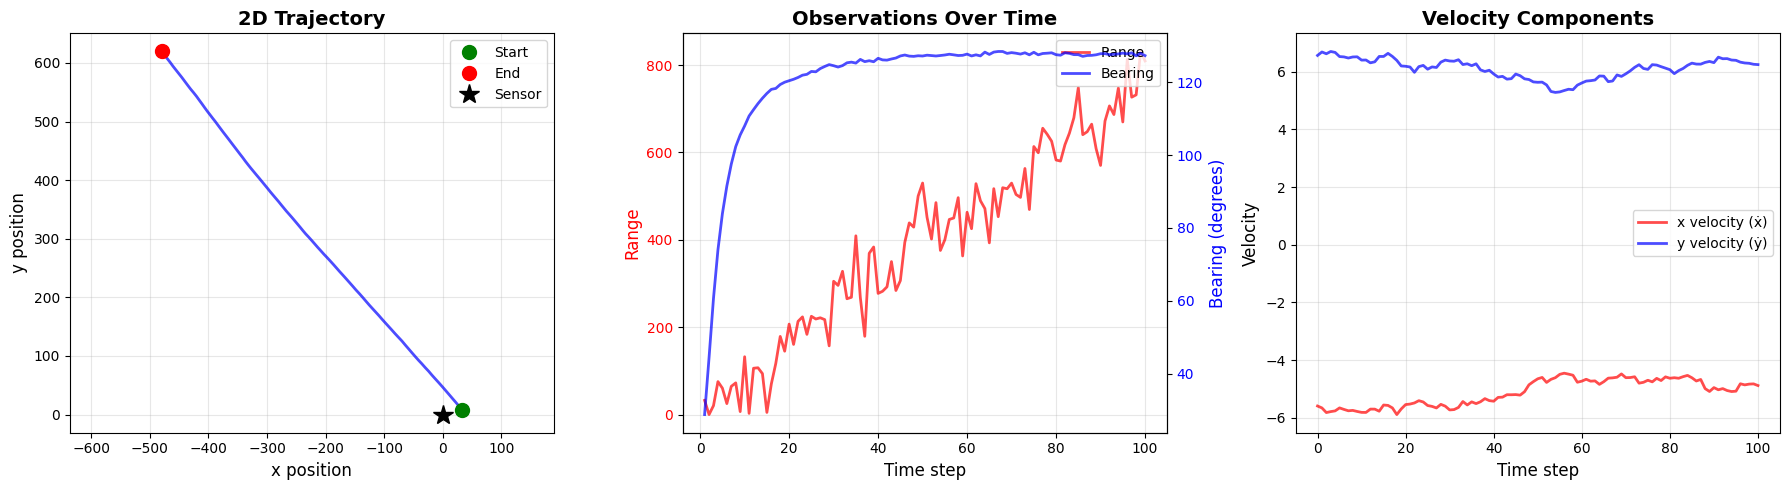

Visualization complete!


In [3]:
states_np = true_states.numpy()
obs_np = obs.numpy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: 2D trajectory
ax = axes[0]
ax.plot(states_np[0, :], states_np[2, :], 'b-', linewidth=2, alpha=0.7)
ax.plot(states_np[0, 0], states_np[2, 0], 'go', markersize=10, label='Start')
ax.plot(states_np[0, -1], states_np[2, -1], 'ro', markersize=10, label='End')
ax.plot(0, 0, 'k*', markersize=15, label='Sensor')
ax.set_xlabel('x position', fontsize=12)
ax.set_ylabel('y position', fontsize=12)
ax.set_title('2D Trajectory', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axis('equal')

# Plot 2: Range and bearing over time
ax = axes[1]
ax2 = ax.twinx()

time_obs = np.arange(1, T+1)
line1 = ax.plot(time_obs, obs_np[0, :], 'r-', linewidth=2, alpha=0.7, label='Range')
line2 = ax2.plot(time_obs, np.degrees(obs_np[1, :]), 'b-', linewidth=2, alpha=0.7, label='Bearing')

ax.set_xlabel('Time step', fontsize=12)
ax.set_ylabel('Range', fontsize=12, color='r')
ax2.set_ylabel('Bearing (degrees)', fontsize=12, color='b')
ax.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelcolor='b')
ax.set_title('Observations Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper right')

# Plot 3: Velocity components over time
ax = axes[2]
time_state = np.arange(0, T+1)
ax.plot(time_state, states_np[1, :], 'r-', linewidth=2, alpha=0.7, label='x velocity (ẋ)')
ax.plot(time_state, states_np[3, :], 'b-', linewidth=2, alpha=0.7, label='y velocity (ẏ)')
ax.set_xlabel('Time step', fontsize=12)
ax.set_ylabel('Velocity', fontsize=12)
ax.set_title('Velocity Components', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("Visualization complete!")

## 3. Define Functions and Jacobians

In [4]:
state_transition_rb = utils.create_state_transition_fn(rb_model)
state_transition_fn = lambda x: state_transition_rb(x) # tf.matmul(model.A, x)

observation_fn_rb = utils.create_observation_fn()
observation_fn = lambda x, model_params=None, no_noise=True: observation_fn_rb(x)

# state_transition_jacobian_fn = lambda x: A # A
state_transition_jacobian_fn_rb = utils.create_state_jacobian_fn(rb_model)
state_transition_jacobian_fn = lambda x, u=None: state_transition_jacobian_fn_rb(x)

observation_jacobian_fn_rb = utils.create_observation_jacobian_fn(rb_model)
observation_jacobian_fn = lambda x, model_params=None: observation_jacobian_fn_rb(x)

In [5]:
# Initialize EKF
x0 = true_states[:,1]
Sigma0 = tf.eye(4, dtype=tf.float32) * 100.0

ekf_edh = ExtendedKalmanFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    Q=rb_model.Q, 
    R=rb_model.R, 
    x0=x0, 
    Sigma0=Sigma0,
    state_transition_jacobian_fn=state_transition_jacobian_fn,
    observation_jacobian_fn=observation_jacobian_fn
)

ekf_ledh = ExtendedKalmanFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    Q=rb_model.Q, 
    R=rb_model.R, 
    x0=x0, 
    Sigma0=Sigma0,
    state_transition_jacobian_fn=state_transition_jacobian_fn,
    observation_jacobian_fn=observation_jacobian_fn
)

In [6]:
model_params= {
    'x0_initial_target_states': tf.expand_dims(x0, 1),
    'P0': Sigma0,
    'state_dim': 4,
    'Q': rb_model.Q,
    'state_dim': rb_model.A.shape[0],
    'Phi': rb_model.A,
    'R': rb_model.R,
    'sim_area_size': 1000.0  # Large surveillance area
}

## 4. Create and Run EDH Filter

In [7]:
# Create EDH filter with global linearization
edh_filter = EDHFilter(
    observation_jacobian=observation_jacobian_fn,
    observation_model=observation_fn,
    n_particle=200,      # Number of particles
    n_lambda=29,         # Number of lambda steps
    lambda_ratio=1.2,    # Exponential spacing ratio
    use_local=False,     # Global linearization (Algorithm 1)
    use_ekf=True,        # Use EKF covariance tracking
    ekf_filter=ekf_edh,      # EKF instance
    verbose=True         # Print progress
)

In [8]:
edh_estimates, edh_particles, edh_covariances = edh_filter.run(
    measurements=obs,
    model_params=model_params
)


Running EDH Filter:
  Particles: 200
  Lambda steps: 29
  Lambda ratio: 1.2
  Linearization: Global (Algorithm 1)
  EKF Covariance: Enabled
  Time steps: 100
  Using provided EKF filter for covariance tracking

Processing time steps...
  Step 10/100
  Step 20/100
  Step 30/100
  Step 40/100
  Step 50/100
  Step 60/100
  Step 70/100
  Step 80/100
  Step 90/100
  Step 100/100

EDH filter completed successfully!
  Estimates shape: (4, 100)
  Particles shape: (4, 200, 100)
  Covariances shape: (4, 4, 100)


<Axes: title={'center': '2D Trajectory'}, xlabel='x position', ylabel='y position'>

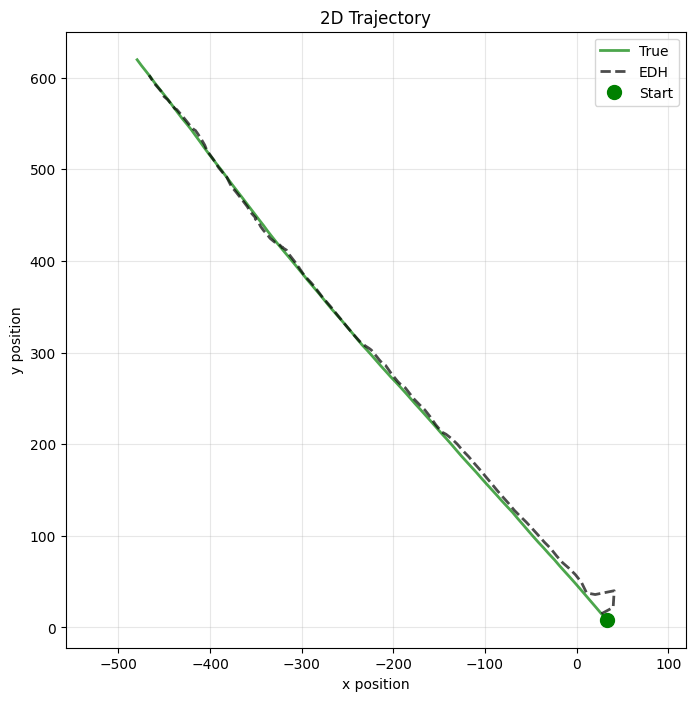

In [9]:
# Plot full comparison using utils
edh_estimates_add = tf.concat((model_params['x0_initial_target_states'], edh_estimates), axis=1)
true_np = true_states.numpy()
filtered_np = edh_estimates_add.numpy()
filtered_dict = {'EDH': filtered_np}
utils.plot_2d_trajectory(true_states, filtered_dict)


In [10]:
edh_pos_error_filtered = utils.compute_position_error(edh_estimates_add, true_states, exclude_first=True)
edh_rmse_filtered = tf.sqrt(tf.reduce_mean(edh_pos_error_filtered**2))
print(f" RMSE erroor: {edh_rmse_filtered.numpy():.2f}")

 RMSE erroor: 23.33


## 5. Create and Run LEDH Filter

In [11]:
# Create EDH filter with global linearization
ledh_filter = EDHFilter(
    observation_jacobian=observation_jacobian_fn,
    observation_model=observation_fn,
    n_particle=200,      # Number of particles
    n_lambda=29,         # Number of lambda steps
    lambda_ratio=1.2,    # Exponential spacing ratio
    use_local=True,     # Global linearization (Algorithm 1)
    use_ekf=True,        # Use EKF covariance tracking
    ekf_filter=ekf_ledh,      # EKF instance
    verbose=True         # Print progress
)

In [15]:
ledh_estimates, ledh_particles, ledh_covariances = ledh_filter.run(
    measurements=obs,
    model_params=model_params
)


Running LEDH Filter:
  Particles: 200
  Lambda steps: 29
  Lambda ratio: 1.2
  Linearization: Local (Algorithm 2)
  EKF Covariance: Enabled
  Time steps: 100
  Using provided EKF filter for covariance tracking

Processing time steps...
  Step 10/100
  Step 20/100
  Step 30/100
  Step 40/100
  Step 50/100
  Step 60/100
  Step 70/100
  Step 80/100
  Step 90/100
  Step 100/100

LEDH filter completed successfully!
  Estimates shape: (4, 100)
  Particles shape: (4, 200, 100)
  Covariances shape: (4, 4, 100)


<Axes: title={'center': '2D Trajectory'}, xlabel='x position', ylabel='y position'>

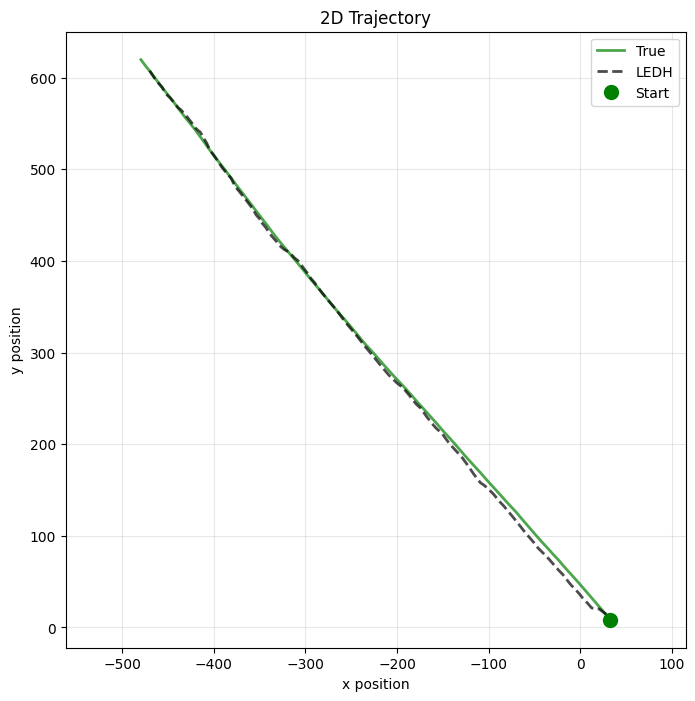

In [16]:
# Plot full comparison using utils
ledh_estimates_add = tf.concat((model_params['x0_initial_target_states'], ledh_estimates), axis=1)
true_np = true_states.numpy()
lfiltered_np = ledh_estimates_add.numpy()
lfiltered_dict = {'LEDH': lfiltered_np}
utils.plot_2d_trajectory(true_states, lfiltered_dict)

In [17]:
ledh_pos_error_filtered = utils.compute_position_error(ledh_estimates_add, true_states, exclude_first=True)
ledh_rmse_filtered = tf.sqrt(tf.reduce_mean(ledh_pos_error_filtered**2))
print(f" RMSE erroor: {ledh_rmse_filtered.numpy():.2f}")

 RMSE erroor: 20.77


## 6. Create and Run PFF Filter